In [59]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from collections import Counter
from nltk.probability import FreqDist

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [60]:
data=pd.read_json('reviews_Office_Products_5.json',lines=True)

data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00000JBLH,"[3, 4]",5,"I bought my first HP12C in about 1984 or so, a...","09 3, 2004",A32T2H8150OJLU,ARH,"A solid performer, and long time friend",1094169600
1,B00000JBLH,"[7, 9]",5,WHY THIS BELATED REVIEW? I feel very obliged t...,"12 15, 2007",A3MAFS04ZABRGO,"Let it Be ""Alan""","Price of GOLD is up, so don't bury the golden ...",1197676800
2,B00000JBLH,"[3, 3]",2,I have an HP 48GX that has been kicking for mo...,"01 1, 2011",A1F1A0QQP2XVH5,Mark B,"Good functionality, but not durable like old HPs",1293840000
3,B00000JBLH,"[7, 8]",5,I've started doing more finance stuff recently...,"04 19, 2006",A49R5DBXXQDE5,R. D Johnson,One of the last of an almost extinct species,1145404800
4,B00000JBLH,"[0, 0]",5,For simple calculations and discounted cash fl...,"08 4, 2013",A2XRMQA6PJ5ZJ8,Roger J. Buffington,Still the best,1375574400


In [61]:
# Data preprocessing
data['overall'] = data['overall'].astype(object) # fix datatype error
dataset = {"reviewText": data["reviewText"], "overall": data["overall"]  }
dataset = pd.DataFrame(data = dataset)
dataset = dataset.dropna()

dataset.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [62]:
dataset.dtypes

reviewText    object
overall       object
dtype: object

In [63]:
dataset['overall']=dataset['overall'].astype('int64')
dataset = dataset[dataset["overall"] != 3] # need datatype=object
dataset.shape

(48198, 2)

In [64]:
dataset["label"] = dataset["overall"].apply(lambda x : 1 if x > 3 else 0)

In [65]:
dataset[dataset["label"].isnull()]

,reviewText,overall,label


In [66]:
dataset.head()

,reviewText,overall,label
0,"I bought my first HP12C in about 1984 or so, a...",5,1
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5,1
2,I have an HP 48GX that has been kicking for mo...,2,0
3,I've started doing more finance stuff recently...,5,1
4,For simple calculations and discounted cash fl...,5,1


In [67]:
dataset.label.value_counts()

1    45342
0     2856
Name: label, dtype: int64

In [68]:
dataset.overall.value_counts()

5    30327
4    15015
2     1726
1     1130
Name: overall, dtype: int64

In [69]:
2856/(2856+45342)

0.05925557077057139

In [70]:
stop_words=set(stopwords.words("english"))

dataset['reviewText']=dataset['reviewText'].str.lower()

dataset['sentence']=dataset['reviewText'].apply(lambda x: sent_tokenize(x))

dataset['tokens']=dataset['reviewText'].apply(lambda x: word_tokenize(x))

In [71]:
def get_clean_token_list(words):
    clean_words=[]
    for word in words:
        flag=True
        for letter in word:
            if letter.isdigit() or letter in string.punctuation:
                flag=False
        if flag:
            clean_words.append(word)
    return clean_words

get_clean_token_list(["hewy","ho!w","are","yo6u","?dd","111","qwerty"])

def remove_stopwords(words):
    """
    pass series get series
    """
    filtered_sent=[]
    for word in words:
        if word not in stop_words:
            filtered_sent.append(word)
    return filtered_sent


remove_stopwords(["hey","how","are","you","?"])

['hey', '?']

In [72]:
dataset['tokens']=dataset['tokens'].apply(remove_stopwords)

dataset['tokens'].head()

0    [bought, first, hp12c, 1984, ,, served, faithf...
1    [belated, review, ?, feel, obliged, share, vie...
2    [hp, 48gx, kicking, twenty, years, hp, 11, 25,...
3    ['ve, started, finance, stuff, recently, went,...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [73]:
dataset['tokens']=dataset['tokens'].apply(get_clean_token_list)

dataset['tokens'].head()

0    [bought, first, served, faithfully, lost, trav...
1    [belated, review, feel, obliged, share, views,...
2    [hp, kicking, twenty, years, hp, years, old, s...
3    [started, finance, stuff, recently, went, look...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [74]:
#Lexicon Normalization
#performing stemming and Lemmatization

# from nltk.stem.wordnet import WordNetLemmatizer
# lem = WordNetLemmatizer()

# from nltk.stem.porter import PorterStemmer
# stem = PorterStemmer()

# word = "troubled"
# print("Lemmatized Word:",lem.lemmatize(word,"v"))
# print("Stemmed Word:",stem.stem(word))

In [75]:
# text="""Hello Mr. Smith, how are you doing today? The weather is great, and city is awesome.
# The sky is pinkish-blue. You shouldn't eat cardboard"""
# tokenized_sent=sent_tokenize(text)
# print(tokenized_sent)

# from nltk.tokenize import word_tokenize
# tokenized_word=word_tokenize(text)
# print(tokenized_word)

In [76]:
stem = PorterStemmer()

def stem_sentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(stem.stem(word))
    return stem_sentence

In [77]:
dataset['stem_sentence']=dataset['tokens'].apply(lambda x: stem_sentence(x))

dataset[['tokens','stem_sentence']]

,tokens,stem_sentence
0,"[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea..."
1,"[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,..."
3,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo..."
4,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, believ, calcul, learn, use, underg..."
6,"[hp, ever, since, first, available, roughly, t...","[hp, ever, sinc, first, avail, roughli, twenti..."
7,"[bought, boss, lost, loves, calculator, would,...","[bought, boss, lost, love, calcul, would, caug..."
8,"[simple, calculator, handles, typical, math, l...","[simpl, calcul, handl, typic, math, larg, easi..."
9,"[love, calculator, big, numbers, calculate, ex...","[love, calcul, big, number, calcul, excel, eas..."


In [78]:
dataset['pos_tag']=dataset['tokens'].apply(lambda x: nltk.pos_tag(x))

dataset['pos_tag']

0        [(bought, VBD), (first, RB), (served, VBN), (f...
1        [(belated, VBN), (review, NN), (feel, NN), (ob...
2        [(hp, NN), (kicking, VBG), (twenty, CD), (year...
3        [(started, VBN), (finance, NN), (stuff, NN), (...
4        [(simple, JJ), (calculations, NNS), (discounte...
5        [(mba, RB), (hard, JJ), (believe, VBP), (calcu...
6        [(hp, NN), (ever, RB), (since, IN), (first, JJ...
7        [(bought, VBN), (boss, NN), (lost, VBN), (love...
8        [(simple, JJ), (calculator, NN), (handles, NNS...
9        [(love, NN), (calculator, NN), (big, JJ), (num...
10       [(mine, NN), (years, NNS), (use, VBP), (almost...
11       [(need, NN), (calculator, NN), (prints, NNS), ...
12       [(great, JJ), (basic, JJ), (calculator, NN), (...
13       [(texas, JJ), (instruments, NNS), (makes, VBZ)...
14       [(review, VB), (second, JJ), (version, NN), (c...
15       [(well, RB), (built, VBN), (calculator, NN), (...
16       [(texas, NN), (instruments, NNS), (solar, JJ),.

In [79]:
# keep only adjective and adverb
keep_tags=["JJ","JJR","JJS","RB","RBR","RBS","UH"]

def filter_tag(pos_list):
    pos_clean_list=[]
    for t in pos_list:
        if t[1] in keep_tags:
            pos_clean_list.append(t[0])
    return pos_clean_list

filter_tag([('asked', 'RB'), ('review', 'NN'), ('scale', 'RBS')])

['asked', 'scale']

In [80]:
dataset['filter_pos_tag']=dataset['pos_tag'].apply(filter_tag)

dataset[['tokens','filter_pos_tag']]

,tokens,filter_pos_tag
0,"[bought, first, served, faithfully, lost, trav...","[first, faithfully, difficult, come, hp, many,..."
1,"[belated, review, feel, obliged, share, views,...","[old, workhorse, anniversary, ower, user, espe..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[old, still, flawless, key, already, hard, ove..."
3,"[started, finance, stuff, recently, went, look...","[recently, good, pleasantly, still, available,..."
4,"[simple, calculations, discounted, cash, flows...","[simple, still, best, used, cpa, financial, co..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, use, undergraduate, still, quick, ..."
6,"[hp, ever, since, first, available, roughly, t...","[ever, first, available, roughly, ago, origina..."
7,"[bought, boss, lost, loves, calculator, would,...","[really, helps, great, little]"
8,"[simple, calculator, handles, typical, math, l...","[simple, typical, large, easy, read, long, eas..."
9,"[love, calculator, big, numbers, calculate, ex...","[big, excellent, easy, much, easier]"


In [81]:
positive_reviews=dataset[dataset['label']==1]['filter_pos_tag']

positive_tokens=[word for review in positive_reviews for word in review]

fdist = FreqDist(positive_tokens)


fdist.most_common(10)


[('great', 18069),
 ('well', 17291),
 ('good', 16007),
 ('easy', 15230),
 ('also', 14882),
 ('really', 12041),
 ('much', 11324),
 ('little', 10610),
 ('nice', 10251),
 ('even', 9159)]

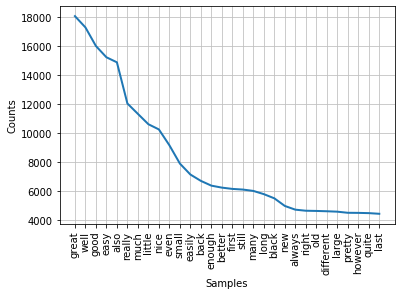

In [82]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [83]:
negative_reviews=dataset[dataset['label']==0]['filter_pos_tag']

negative_tokens=[word for review in negative_reviews for word in review]

fdist = FreqDist(negative_tokens)


fdist.most_common(10)


[('even', 1058),
 ('good', 924),
 ('really', 853),
 ('well', 843),
 ('much', 830),
 ('also', 818),
 ('back', 724),
 ('first', 708),
 ('better', 607),
 ('still', 543)]

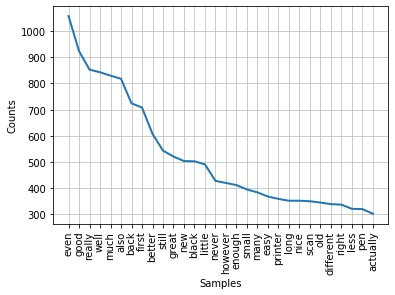

In [84]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [85]:
dataset[dataset['label']==0].iloc[25].values

array(['the wrist pad i brought a couple of months ago had a terrible smell when i purchased it and the smell is still there but not as strong. now the gel is coming out at the seams.  i cannot use the wrist rest and i tried to fix it but it cannot be fixed.  i would not recommend this item.',
       1, 0,
       list(['the wrist pad i brought a couple of months ago had a terrible smell when i purchased it and the smell is still there but not as strong.', 'now the gel is coming out at the seams.', 'i cannot use the wrist rest and i tried to fix it but it cannot be fixed.', 'i would not recommend this item.']),
       list(['wrist', 'pad', 'brought', 'couple', 'months', 'ago', 'terrible', 'smell', 'purchased', 'smell', 'still', 'strong', 'gel', 'coming', 'seams', 'use', 'wrist', 'rest', 'tried', 'fix', 'fixed', 'would', 'recommend', 'item']),
       list(['wrist', 'pad', 'brought', 'coupl', 'month', 'ago', 'terribl', 'smell', 'purchas', 'smell', 'still', 'strong', 'gel', 'come', 'seam',

In [86]:
dataset['clean_sentence']=dataset['filter_pos_tag'].apply(lambda x: ' '.join(x))

### Sentiment analysis using TextBlob Library

In [99]:
from textblob import TextBlob
from textblob import Word

In [100]:
def detect_polarity(col):
    return TextBlob(col).sentiment.polarity
def detect_subjectivity(col):
    return TextBlob(col).sentiment.subjectivity
def get_lemma(col):
    lemma_list = []
    text = TextBlob(col).words
    for item in text:
        lemma = Word(item).lemmatize()
        lemma_list.append(lemma)
    return lemma_list

In [102]:
filter_method = lambda x:'Highly Positive' if x >= 0.5 else 'Fairly Positive' if (x > 0 and x < 0.5) else 'Highly Negative' if x <= -0.5 else 'Fairly Negative' if (x > -0.5 and x < 0) else 'Neutral'

In [104]:
# dataset['polarity'] = round(dataset.clean_sentence.apply(detect_polarity),1)
# dataset['subjectivity'] = round(dataset.clean_sentence.apply(detect_subjectivity),1)
# dataset['sentiment'] = dataset['polarity'].apply(filter_method)
# dataset['lemma'] = dataset.clean_sentence.apply(get_lemma)
# dataset.head(6)

,reviewText,overall,label,sentence,tokens,stem_sentence,pos_tag,filter_pos_tag,clean_sentence,polarity,subjectivity,sentiment,lemma
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, difficult, come, hp, many,...",first faithfully difficult come hp many hp hp ...,0.2,0.5,Fairly Positive,"[first, faithfully, difficult, come, hp, many,..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[old, workhorse, anniversary, ower, user, espe...",old workhorse anniversary ower user especially...,0.1,0.5,Fairly Positive,"[old, workhorse, anniversary, ower, user, espe..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[old, still, flawless, key, already, hard, ove...",old still flawless key already hard overall ne...,0.3,0.5,Fairly Positive,"[old, still, flawless, key, already, hard, ove..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[(started, VBN), (finance, NN), (stuff, NN), (...","[recently, good, pleasantly, still, available,...",recently good pleasantly still available hp gr...,0.3,0.4,Fairly Positive,"[recently, good, pleasantly, still, available,..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, still, best, used, cpa, financial, co...",simple still best used cpa financial complex e...,0.3,0.4,Fairly Positive,"[simple, still, best, used, cpa, financial, co..."
5,"while i don't have an mba, it's hard to believ...",5,1,"[while i don't have an mba, it's hard to belie...","[mba, hard, believe, calculator, learned, use,...","[mba, hard, believ, calcul, learn, use, underg...","[(mba, RB), (hard, JJ), (believe, VBP), (calcu...","[mba, hard, use, undergraduate, still, quick, ...",mba hard use undergraduate still quick financi...,0.0,0.3,Neutral,"[mba, hard, use, undergraduate, still, quick, ..."


In [164]:
dataset['polarity'] = round(dataset.reviewText.apply(detect_polarity),1)
dataset['subjectivity'] = round(dataset.reviewText.apply(detect_subjectivity),1)
dataset['sentiment'] = dataset['polarity'].apply(filter_method)
dataset['lemma'] = dataset.reviewText.apply(get_lemma)
dataset.head(6)

,reviewText,overall,label,sentence,tokens,stem_sentence,pos_tag,filter_pos_tag,clean_sentence,polarity,subjectivity,sentiment,lemma,index,positive_sentence
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, difficult, come, hp, many,...",first faithfully difficult come hp many hp hp ...,0.2,0.5,1,"[i, bought, my, first, hp12c, in, about, 1984,...",0,1
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[old, workhorse, anniversary, ower, user, espe...",old workhorse anniversary ower user especially...,0.2,0.5,1,"[why, this, belated, review, i, feel, very, ob...",1,1
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[old, still, flawless, key, already, hard, ove...",old still flawless key already hard overall ne...,0.2,0.5,1,"[i, have, an, hp, 48gx, that, ha, been, kickin...",2,1
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[(started, VBN), (finance, NN), (stuff, NN), (...","[recently, good, pleasantly, still, available,...",recently good pleasantly still available hp gr...,0.2,0.5,1,"[i, 've, started, doing, more, finance, stuff,...",3,1
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, still, best, used, cpa, financial, co...",simple still best used cpa financial complex e...,0.4,0.5,1,"[for, simple, calculation, and, discounted, ca...",4,1
5,"while i don't have an mba, it's hard to believ...",5,1,"[while i don't have an mba, it's hard to belie...","[mba, hard, believe, calculator, learned, use,...","[mba, hard, believ, calcul, learn, use, underg...","[(mba, RB), (hard, JJ), (believe, VBP), (calcu...","[mba, hard, use, undergraduate, still, quick, ...",mba hard use undergraduate still quick financi...,0.0,0.3,1,"[while, i, do, n't, have, an, mba, it, 's, har...",5,1


In [165]:
dataset.sentiment.value_counts()

1    45650
0     2548
Name: sentiment, dtype: int64

In [166]:
dataset.label.value_counts()

1    45342
0     2856
Name: label, dtype: int64

In [167]:
dataset.subjectivity.value_counts()

0.5    17609
0.6    12600
0.4     8491
0.7     4416
0.3     1959
0.8     1685
0.2      485
0.9      365
1.0      237
0.0      236
0.1      115
Name: subjectivity, dtype: int64

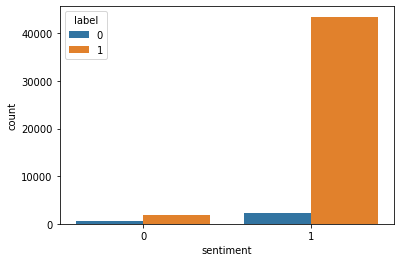

In [168]:

sns.countplot(x="sentiment", hue="label", data=dataset)

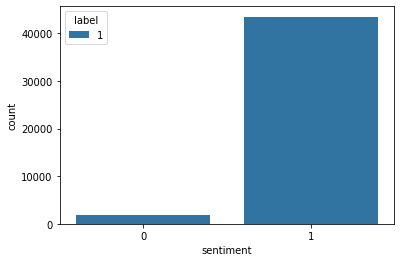

In [169]:
sns.countplot(x="sentiment", hue="label", data=dataset[dataset['label']==1])

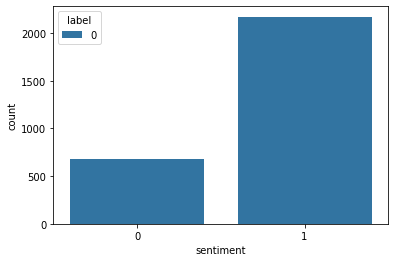

In [170]:
sns.countplot(x="sentiment", hue="label", data=dataset[dataset['label']==0])

In [175]:
dataset[(dataset['label']==1) & (dataset['sentiment']==0)].shape

(1864, 15)

In [176]:
dataset[(dataset['label']==0) & (dataset['sentiment']==0)].shape

(684, 15)

In [150]:
filter_method = lambda x: 1 if x>0 else 0 if x<0 else 1 if math.atan2(0.0, -0.0) == math.atan2(x, -0.0) else 0

In [177]:
confusion_matrix(dataset['label'],dataset['sentiment'])

array([[  684,  2172],
       [ 1864, 43478]])

In [178]:
get_model_metrics(dataset['label'],dataset['sentiment'])

Accuracy    : 0.92
Sensitivity : 0.96
Specificity : 0.24
Precision   : 0.95
Recall      : 0.96
F1_score    : 0.91


In [179]:
dataset[['filter_pos_tag','lemma']]

,filter_pos_tag,lemma
0,"[first, faithfully, difficult, come, hp, many,...","[i, bought, my, first, hp12c, in, about, 1984,..."
1,"[old, workhorse, anniversary, ower, user, espe...","[why, this, belated, review, i, feel, very, ob..."
2,"[old, still, flawless, key, already, hard, ove...","[i, have, an, hp, 48gx, that, ha, been, kickin..."
3,"[recently, good, pleasantly, still, available,...","[i, 've, started, doing, more, finance, stuff,..."
4,"[simple, still, best, used, cpa, financial, co...","[for, simple, calculation, and, discounted, ca..."
5,"[mba, hard, use, undergraduate, still, quick, ...","[while, i, do, n't, have, an, mba, it, 's, har..."
6,"[ever, first, available, roughly, ago, origina...","[i, 've, had, an, hp, 12c, ever, since, they, ..."
7,"[really, helps, great, little]","[bought, this, for, my, bos, because, he, lost..."
8,"[simple, typical, large, easy, read, long, eas...","[this, is, a, well-designed, simple, calculato..."
9,"[big, excellent, easy, much, easier]","[i, love, this, calculator, big, number, and, ..."


In [87]:
# TODO emoticon , acronymns mapping, exclusion list

In [160]:
#Function to calculate Model Metrics

def get_model_metrics(actual,predicted):
    """
    Print Summary Metrics of the Model

    Parameters:
    actual (pandas.core.series.Series): Series of Boolean values for target column
    predicted (pandas.core.series.Series): Series of Boolean values for Model predicted the target column
    
    Returns:
    None

   """

    
    confusion = metrics.confusion_matrix(actual,predicted )
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    accuracy=metrics.accuracy_score(actual,predicted)
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    precision=TP/float(FP+TP)
    recall=TP/float(FN+TP)
    
    precision=metrics.precision_score(actual,predicted)
    recall=metrics.recall_score(actual,predicted)
    f1=metrics.f1_score(actual,predicted, average='weighted') 
    print("Accuracy    : "+str(round(accuracy,2)))
    print("Sensitivity : "+str(round(sensitivity,2)))
    print("Specificity : "+str(round(specificity,2)))
    print("Precision   : "+str(round(precision,2)))
    print("Recall      : "+str(round(recall,2)))
    print("F1_score    : "+str(round(f1,2)))

def get_cross_validated_model_metrics(X,y,cv=5):
    """
    Get cross validated model metric for k folds

    Parameters:
    X (pandas.core.frame.DataFrame): DF of all the features excluding target column
    y (pandas.core.series.Series): Series of Boolean values of the target column
    
    Returns:
    df (pandas.core.frame.DataFrame): DF will all the metric for k fold

   """
    accuracy=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='accuracy')
    precision=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='precision')
    recall=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='recall')
    f1_weighted=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='f1_weighted')
    roc_auc=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='roc_auc')
    df=pd.DataFrame(
    {'accuracy': accuracy,
     'precision': precision,
     'recall': recall,
     'f1_weighted': f1_weighted,
     'roc_auc': roc_auc,
    })
    return df

logregcv = LogisticRegressionCV(class_weight='balanced',cv=5)

In [89]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(dataset, columns = ["clean_sentence"])
y = pd.DataFrame(dataset, columns = ["label"])

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=50,stratify=y,train_size=0.7)

In [90]:
X_train.head()

,clean_sentence
30346,bold clean solid really back even immediately ...
466,avery best easy old simple clear great also ma...
4335,first continually new comfortable high
37664,many decent really decide attractive directly ...
35986,read important future scotch much much removab...


In [91]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_vector = vectorizer.fit_transform(X_train["clean_sentence"])
test_vector = vectorizer.transform(X_test["clean_sentence"])

In [92]:
X_train["clean_sentence"].head()

30346    bold clean solid really back even immediately ...
466      avery best easy old simple clear great also ma...
4335                first continually new comfortable high
37664    many decent really decide attractive directly ...
35986    read important future scotch much much removab...
Name: clean_sentence, dtype: object

In [93]:
log_reg_model = LogisticRegressionCV(class_weight='balanced')
log_reg_model.fit(train_vector, y_train)
scores = log_reg_model.score(test_vector, y_test) # accuracy
print(scores)

0.8830567081604426


In [94]:
#Making prediction on the train data
y_train_pred = log_reg_model.predict_proba(train_vector)[:,1]

In [95]:
#Making prediction on the test data
y_pred = log_reg_model.predict_proba(test_vector)[:,1]

In [96]:
y_train_pred=pd.Series(y_train_pred)
y_pred=pd.Series(y_pred)

In [97]:
y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.5 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.5 else 0)

In [98]:
metrics.confusion_matrix(y_train,y_train_pred_bool)

array([[ 1937,    62],
       [ 1366, 30373]])

In [41]:
get_model_metrics(y_train,y_train_pred_bool)

Accuracy    : 0.96
Sensitivity : 0.96
Specificity : 0.97
Precision   : 1.0
Recall      : 0.96
F1_score    : 0.96


In [42]:
metrics.confusion_matrix(y_test,y_pred_bool)

array([[  424,   433],
       [ 1258, 12345]])

In [43]:
get_model_metrics(y_test,y_pred_bool)

Accuracy    : 0.88
Sensitivity : 0.91
Specificity : 0.49
Precision   : 0.97
Recall      : 0.91
F1_score    : 0.9


In [44]:
train_output=pd.DataFrame({'y_train':y_train['label'],'y_pred':y_train_pred,'y_train_pred_bool':y_train_pred_bool})
test_output=pd.DataFrame({'y_test':y_test['label'],'y_pred':y_pred,'y_pred_bool':y_pred_bool})

In [45]:
train_output['y_train'].fillna(0,inplace=True)
test_output['y_test'].fillna(0,inplace=True)

In [46]:
train_output.head(10)

,y_train,y_pred,y_train_pred_bool
0,0.0,0.051766,0.0
1,1.0,0.999967,1.0
2,0.0,0.436841,0.0
3,1.0,1.000000,1.0
4,1.0,0.704796,1.0
5,0.0,0.956414,1.0
6,1.0,0.999300,1.0
7,1.0,0.999999,1.0
8,1.0,0.708916,1.0
9,0.0,0.746341,1.0


In [47]:
test_output.head(10)

,y_test,y_pred,y_pred_bool
0,1.0,0.271726,0.0
1,0.0,0.014110,0.0
2,0.0,1.000000,1.0
3,0.0,0.180575,0.0
4,0.0,0.953813,1.0
5,1.0,0.999461,1.0
6,0.0,1.000000,1.0
7,0.0,0.976987,1.0
8,0.0,0.996756,1.0
9,1.0,0.999745,1.0


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_train,y_train_pred , drop_intermediate = False )

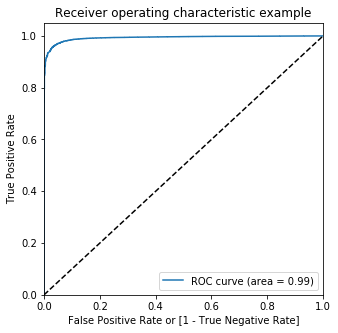

In [50]:
draw_roc(y_train,y_train_pred)

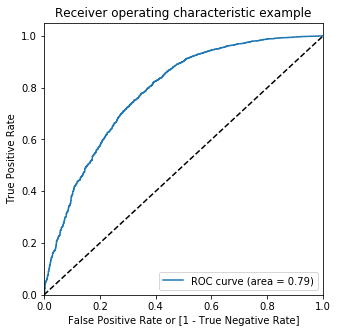

In [51]:
draw_roc(y_test,y_pred)

In [52]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# confusion=confusion_matrix(df['y'],df['y_prob'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def threshold_optimization(y,num):
    #pass the prediction_probability series and threshold probabilty cutoff
    y_bool= y.apply(lambda x: 1 if x>=num else -1)
    return y_bool

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train,threshold_optimization(y_train_pred,i))
#     print(cm1)
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensi  speci
0.0   0.0  0.940749    1.0    0.0
0.1   0.1  0.000000    0.0    NaN
0.2   0.2  0.000000    0.0    NaN
0.3   0.3  0.000000    0.0    NaN
0.4   0.4  0.000000    0.0    NaN
0.5   0.5  0.000000    0.0    NaN
0.6   0.6  0.000000    0.0    NaN
0.7   0.7  0.000000    0.0    NaN
0.8   0.8  0.000000    0.0    NaN
0.9   0.9  0.000000    0.0    NaN


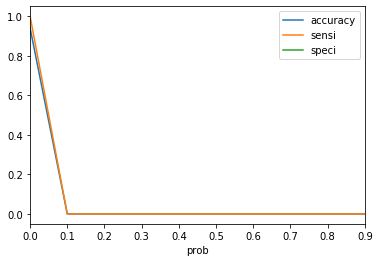

In [53]:

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [54]:
cross_validated_train_metrics=get_cross_validated_model_metrics(train_vector, y_train,5)

In [55]:
cross_validated_train_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.880261,0.964609,0.905955,0.897869,0.778740
1,0.890782,0.967505,0.914619,0.905769,0.800183
2,0.881743,0.961423,0.910838,0.897560,0.745409
3,0.883076,0.962710,0.910996,0.898935,0.757161
4,0.882745,0.962230,0.911139,0.898554,0.750228


In [56]:
cross_validated_train_metrics.mean()

accuracy       0.883722
precision      0.963696
recall         0.910709
f1_weighted    0.899737
roc_auc        0.766344
dtype: float64

In [57]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import RegexpTokenizer
# #tokenizer to remove unwanted elements from out data like symbols and numbers
# token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# text_counts= cv.fit_transform(X_train["clean_sentence"])

In [58]:
# # get all unique words in the corpus
# vocab = vectorizer.get_feature_names()
# # show document feature vectors
# pd.DataFrame(train_vector, columns=vocab)

ValueError: Shape of passed values is (33738, 1), indices imply (33738, 16237)

In [ ]:

# # you can set the n-gram range to 1,2 to get unigrams as well as bigrams
# bv = CountVectorizer(ngram_range=(2,2))
# bv_matrix = bv.fit_transform(norm_corpus)

# bv_matrix = bv_matrix.toarray()
# vocab = bv.get_feature_names()
# pd.DataFrame(bv_matrix, columns=vocab)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
# tv_matrix = tv.fit_transform(norm_corpus)
# tv_matrix = tv_matrix.toarray()

# vocab = tv.get_feature_names()
# pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# similarity_matrix = cosine_similarity(tv_matrix)
# similarity_df = pd.DataFrame(similarity_matrix)
# similarity_df

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# Z = linkage(similarity_matrix, 'ward')
# pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object')

In [ ]:
# plt.figure(figsize=(8, 3))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Data point')
# plt.ylabel('Distance')
# dendrogram(Z)
# plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:

# from scipy.cluster.hierarchy import fcluster
# max_dist = 1.0

# cluster_labels = fcluster(Z, max_dist, criterion='distance')
# cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
# pd.concat([corpus_df, cluster_labels], axis=1)

In [ ]:
# from sklearn.decomposition import LatentDirichletAllocation

# lda = LatentDirichletAllocation(n_topics=3, max_iter=10000, random_state=0)
# dt_matrix = lda.fit_transform(cv_matrix)
# features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
# features

In [ ]:
# tt_matrix = lda.components_
# for topic_weights in tt_matrix:
#     topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
#     topic = sorted(topic, key=lambda x: -x[1])
#     topic = [item for item in topic if item[1] > 0.6]
#     print(topic)
#     print()

In [ ]:
# from sklearn.cluster import KMeans

# km = KMeans(n_clusters=3, random_state=0)
# km.fit_transform(features)
# cluster_labels = km.labels_
# cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
# pd.concat([corpus_df, cluster_labels], axis=1)